# Split into Train / Valid / Test set

## Load Dataset from sklearn

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()

In [3]:
df = pd.DataFrame(california.data, columns=california.feature_names)
df["Target"] = california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


## Convert to PyTorch Tensor

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
data = torch.from_numpy(df.values).float()

x = data[:,:-1]
y = data[:,-1:]

print(x.size(),y.size())

torch.Size([20640, 8]) torch.Size([20640, 1])


In [6]:
# Train / Valid / Test ratio
ratios = [.6, .2, .2]

In [7]:
train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

Train 12384 / Valid 4128 / Test 4128 samples.


In [8]:
# Shuffle before split.
indices = torch.randperm(data.size(0))
x = torch.index_select(x, dim=0, index = indices)
y = torch.index_select(y, dim=0, index = indices)

# Split train, valid and test set with each count.
x = list(x.split(cnts, dim = 0))
y = y.split(cnts,dim = 0)

for x_i,y_i in zip(x,y):
    print(x_i.size(), y_i.size())

torch.Size([12384, 8]) torch.Size([12384, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])


## Preprocessing

In [10]:
scaler = StandardScaler()
scaler.fit(x[0].numpy()) # You must fit with train data only.

x[0] = torch.from_numpy(scaler.transform(x[0].numpy())).float()
x[1] = torch.from_numpy(scaler.transform(x[1].numpy())).float()
x[2] = torch.from_numpy(scaler.transform(x[2].numpy())).float()

df = pd.DataFrame(x[0].numpy(), columns=california.feature_names)
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
12379,-0.844427,-0.290034,-0.390973,-0.193492,0.773926,0.044541,-0.570514,-0.160670
12380,-0.104444,-1.645241,0.441765,-0.154938,-0.665525,-0.043705,-0.533335,1.143440
12381,-0.335871,-0.608906,-0.345269,-0.043892,-0.373449,-0.097459,-1.314111,1.163423
12382,0.000571,-0.529188,-0.031440,-0.328356,-0.797459,-0.051941,1.418604,-0.875183
12383,1.243497,0.188275,0.185320,-0.218160,-0.132328,-0.036870,0.907383,-1.214951


## Build Model & Optimizer

In [11]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1)),
)

model

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)

In [12]:
optimizer = optim.Adam(model.parameters())

## Train

In [13]:
n_epochs = 4000
batch_size = 256
print_interval = 100

In [14]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 100
lowest_epoch = np.inf

In [15]:
train_history, valid_history = [], []

for i in range(n_epochs):
    # Shuffle before mini-batch split.
    indices = torch.randperm(x[0].size(0))
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    # |x_| = (total_size, input_dim)
    # |y_| = (total_size, output_dim)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    # |x_[i]| = (batch_size, input_dim)
    # |y_[i]| = (batch_size, output_dim)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in zip(x_, y_):
        # |x_i| = |x_[i]|
        # |y_i| = |y_[i]|
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()        
        train_loss += float(loss)

    train_loss = train_loss / len(x_)

    # You need to declare to PYTORCH to stop build the computation graph.
    with torch.no_grad():
        # You don't need to shuffle the validation set.
        # Only split is needed.
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.mse_loss(y_hat_i, y_i)
            
            valid_loss += loss
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(x_)
    
    # Log each loss to plot after training is done.
    train_history += [train_loss]
    valid_history += [valid_loss]
        
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        # 'state_dict()' returns model weights as key-value.
        # Take a deep copy, if the valid loss is lowest ever.
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))

# Load best epoch's model.
model.load_state_dict(best_model)

Epoch 100: train loss=3.4534e-01  valid_loss=3.7005e-01  lowest_loss=3.7010e-01
Epoch 200: train loss=3.2719e-01  valid_loss=3.5302e-01  lowest_loss=3.5208e-01
Epoch 300: train loss=3.1048e-01  valid_loss=3.3998e-01  lowest_loss=3.3223e-01
Epoch 400: train loss=3.0714e-01  valid_loss=3.3063e-01  lowest_loss=3.2972e-01
Epoch 500: train loss=3.0317e-01  valid_loss=3.3373e-01  lowest_loss=3.2708e-01
Epoch 600: train loss=3.0450e-01  valid_loss=3.3663e-01  lowest_loss=3.2538e-01
Epoch 700: train loss=3.0112e-01  valid_loss=3.2513e-01  lowest_loss=3.2399e-01
Epoch 800: train loss=3.0260e-01  valid_loss=3.2644e-01  lowest_loss=3.2301e-01
Epoch 900: train loss=2.9964e-01  valid_loss=3.2168e-01  lowest_loss=3.2130e-01
Epoch 1000: train loss=2.9857e-01  valid_loss=3.2074e-01  lowest_loss=3.1995e-01
Epoch 1100: train loss=2.9912e-01  valid_loss=3.2508e-01  lowest_loss=3.1913e-01
Epoch 1200: train loss=2.9767e-01  valid_loss=3.2084e-01  lowest_loss=3.1837e-01
Epoch 1300: train loss=2.9819e-01  va

<All keys matched successfully>

## Loss History

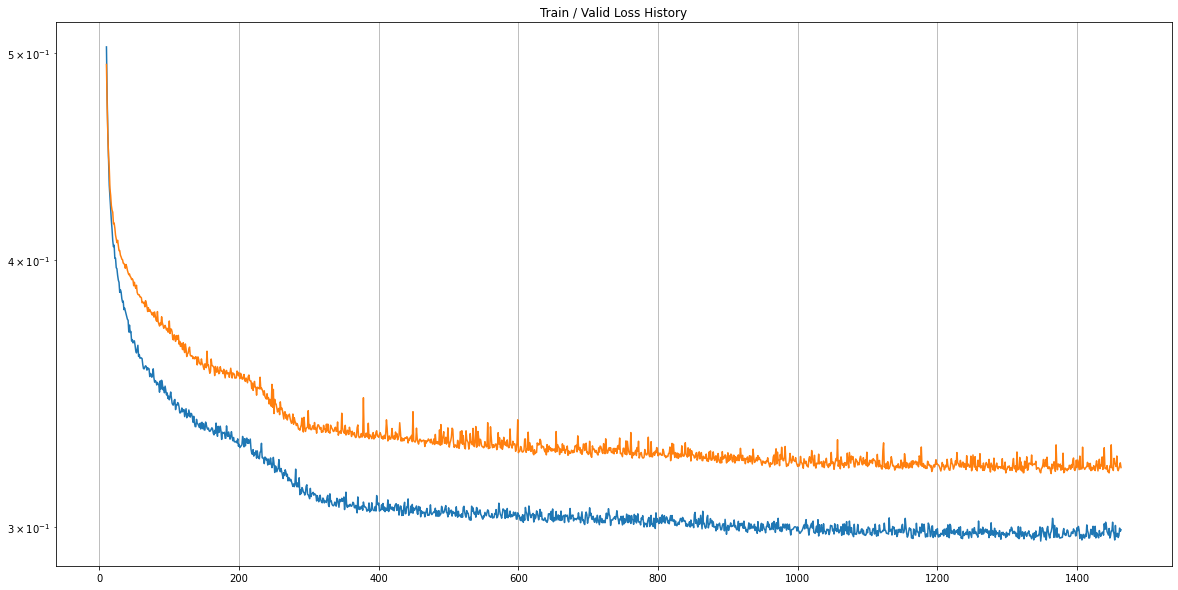

In [16]:
plot_from = 10

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

## Let's see the result!

In [17]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        test_loss += loss # Gradient is already detached.

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history),
                        key=lambda x: x[1])

print("Train loss: %.4e" % sorted_history[0][0])
print("Valid loss: %.4e" % sorted_history[0][1])
print("Test loss: %.4e" % test_loss)

Train loss: 2.9842e-01
Valid loss: 3.1766e-01
Test loss: 2.9622e-01


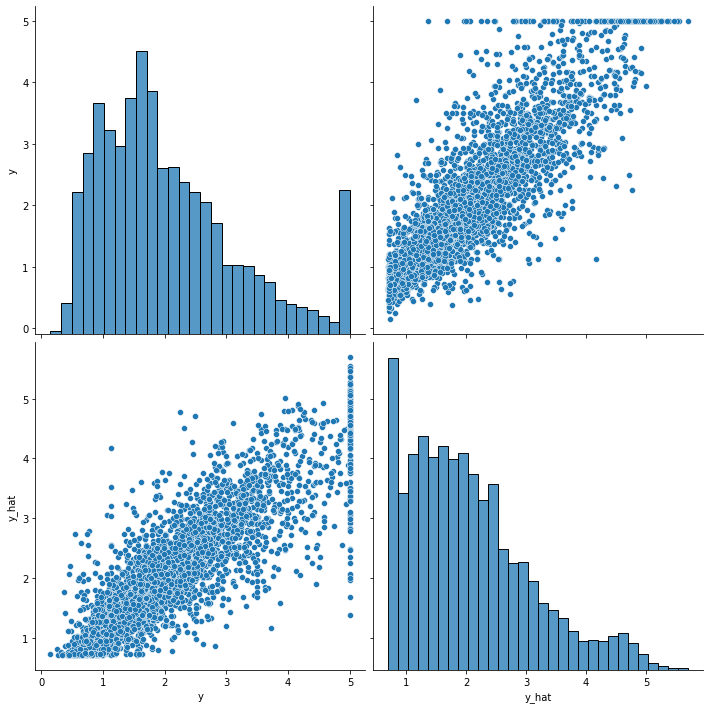

In [18]:
df = pd.DataFrame(torch.cat([y[2], y_hat], dim=1).detach().numpy(),
                  columns=["y", "y_hat"])

sns.pairplot(df, height=5)
plt.show()